In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
#generate data
train_n = 100
test_n = 10000
d = 200
X_train = np.random.normal(0,1, size=(train_n,d))
a_true = np.random.normal(0,1, size=(d,1))
y_train = X_train.dot(a_true) + np.random.normal(0,0.5,size=(train_n,1))
X_test = np.random.normal(0,1, size=(test_n,d))
y_test = X_test.dot(a_true) + np.random.normal(0,0.5,size=(test_n,1))

In [3]:
def GetSMatrix(X):
    S = np.zeros((len(X[0]),len(X[0])))
    mean = np.mean(X, axis = 0).reshape(-1,1)
    for x in X:
        xx = x.reshape(-1,1)
        S += (xx - mean) @ (xx - mean).T
    return S

def GetMainVector(X, dimension):
    S = GetSMatrix(X)
    eigvalue, eigvector = np.linalg.eig(S)
    #kmax_eigvalue = eigvalue.argsort()[-dimension:]
    kmax_eigvalue_index = np.argpartition(eigvalue, -dimension)[-dimension:]
    W = eigvector[:,kmax_eigvalue_index]
    return W

In [4]:
dimension = 150
M = GetMainVector(X_train, dimension)
X_train = X_train @ M
X_test = X_test @ M
print(X_train.shape)
print(y_train.shape)

(100, 150)
(100, 1)


In [5]:
def getGradient(X, y, a, index, lambda_value = 0):
    #gradient below is for index -> a_t
    #gradient = 2 * (X@a  - y).T @ (X[:,index])
    #now change into index -> x_i
    gradient = (2 * (X[index]@a-y[index]) * X[index]).reshape(-1,1) + (2 * lambda_value * a).reshape(-1,1)
    return gradient.reshape((-1,1))
#using another metric, y2 is the real ture output
def NormMSELoss(y1, y2):
    return np.sqrt(np.sum((y1 - y2)**2))/np.sqrt(np.sum(y2**2))
def SGDTrain(X, y, step_size, iters, metric, batch_size=1, evaluate = False, lambda_value = 0, random_radius = 0):
    a = np.random.uniform(0,random_radius, size = (len(X[0]),1))
    obj_value = np.zeros(iters+1)
    test_error = np.zeros(iters//100 + 1)
    obj_value[0] = metric(X @ a, y)
    if evaluate:
        global X_test, y_test
        test_error[0] = metric(X_test @ a, y_test)
    for i in range(iters):
        gd = np.zeros((len(X[0]),1))
        indexs = np.array(range(len(X)))
        np.random.shuffle(indexs)
        for index_i in range(batch_size):
            index = indexs[index_i]
            gd += getGradient(X, y, a, index, lambda_value).astype(np.float64)
        #update a with gradient
        a = a - step_size * gd
        obj_value[i+1] = metric(X @ a, y)
        if evaluate and (i+1) % 100 == 0:
            test_error[(i+1)//100] = metric(X_test @ a, y_test)
    if evaluate:
        return obj_value, test_error
    else:
        return obj_value

/home/temple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  
/home/temple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
/home/temple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
/home/temple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
/home/temple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


|    5e-05|      0.004207|  0.721148|


Text(0.5,1,'step size = 5e-05')

Text(0.5,0,'iteraion')

Text(0,0.5,'normalized error')

|   0.0005|      0.000531|  0.115127|


Text(0.5,1,'step size = 0.0005')

Text(0.5,0,'iteraion')

Text(0,0.5,'normalized error')

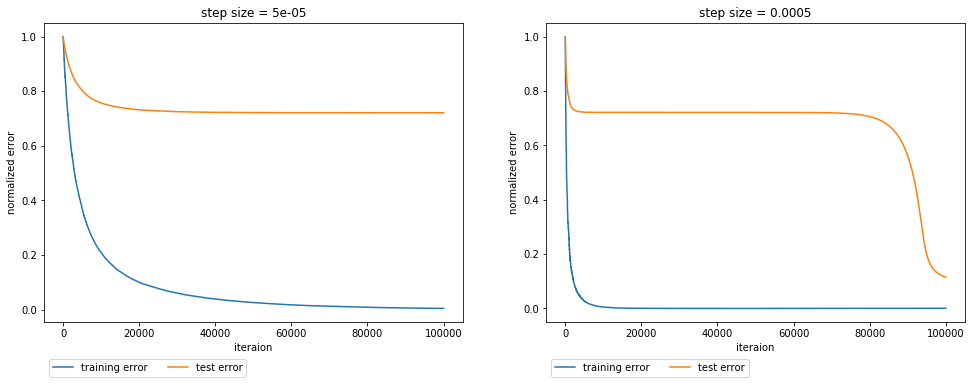

average running time = 29.7529225 s


In [6]:
trial_times = 1
train_iter = 100000
step_size_list =  [0.00005,0.0005]
plt.figure(figsize=(3*(len(step_size_list)+3.5),(len(step_size_list)+3.5)));

total_running_time = 0
for i in range(len(step_size_list)):
    #for 10 times
    running_time = 0
    total_training_errors = np.zeros(train_iter+1)
    total_test_errors = np.zeros(train_iter//100+1)
    
    for _ in range(trial_times):
        running_start = time.clock()
        training_errors, test_errors = SGDTrain(X_train, y_train, step_size_list[i], train_iter,\
                                             NormMSELoss, evaluate = True)
        running_time += time.clock() - running_start
        total_training_errors += training_errors
        total_test_errors += test_errors

    total_running_time += running_time / trial_times
    
    print('|%9.4g|      %6lf|  %6lf|' %(step_size_list[i], \
                                        total_training_errors[-1]/trial_times, \
                                        total_test_errors[-1]/trial_times))
    
    x_index1 = list(range(0,train_iter+1,1))
    x_index2 = list(range(0,train_iter+1,100))
    
    plt.subplot(1,len(step_size_list),i+1);
    plt.title('step size = ' + str(step_size_list[i]));
    plt.xlabel('iteraion');
    plt.ylabel('normalized error');
    plt.plot(x_index1, total_training_errors/trial_times);
    plt.plot(x_index2, total_test_errors/trial_times);
    
    #draw base line
    plt.legend(['training error', 'test error'],\
              bbox_to_anchor = (0,-0.2), loc = 3, ncol = 2);

plt.show();
print('average running time =', total_running_time / len(step_size_list), 's')